# **Recherche en grille** : `BertVectorizer`

La complexité spatiale $\mathcal{O}(m \times n \times d)$ de BERT est fonction de la taille de lot (`batch_size`, dénotée par $m$), de la longueur maximale de séquence (`max_length`, dénotée par $n$), et de $d$ la dimension de l'espace d'embedding de BERT (par exemple, 768 pour *BERT-base*).

Cela signifie que l'espace mémoire requis pour stocker les embeddings BERT augmente avec la taille de lot et la longueur maximale de séquence. Par exemple, pour un `batch_size` de 32 et une `max_length` de 512 (le maximum possible pour *BERT-base*), avec la dimension d'embedding de 768, la complexité spatiale serait de de l'ordre de $32 \times 512 \times 768 = 12\,582\,912$.

Le paramètre $d$ étant fixe, compte tenu de la mémoire maximale $M$ que le système peut délivrer pour l'opération, on voit que $\displaystyle M = mnd \Leftrightarrow m = \frac{1}{n}\left(\frac{M}{d}\right)$.

Augmenter $n$ augmente a priori la qualité des prédictions, mais entraine une alongement du temps de traitement et surtout de la pression sur la mémoire.

# Chargement des corpus prétraités

In [1]:
from tx_pipeline import tx_ml_preprocess
from tx_pipeline import tx_ml_bert
from gridsearch import flipkart_gridsearch
from pepper_utils import cls
import matplotlib.pyplot as plt

names = ['product_name', 'description']
corpora = {}
for name in names:
    corpora[name] = tx_ml_preprocess(name)

# Réglages mono-paramètre

In [2]:
corpus_name = "product_name"
pipeline = tx_ml_bert
ex_params_name = 'bert_params'
# 'max_length': 64,  # Max of 512 with bert-base-uncased (hidden_size)
# 'batch_size': None,  # `None` means no batch
ex_param_domain_defs = {"max_length": 64, "batch_size": 10}
gridsearch_data, _ = flipkart_gridsearch(
    pipeline, corpora, corpus_name,
    ex_params_name, ex_param_domain_defs,
    verbosity=2,
    include_fixed=["max_length", "batch_size"]
)
cls()
display(gridsearch_data)

,max_length,batch_size,n_docs,n_sents,n_feats,n_rd_feats,ari,comb_ari,extractor_time,reductor_time,classifier_time,show_time,total_time
0,64,10,1050,1050,768,2,0.103127,0.103127,83.412405,4.978406,0.563672,1.817719,90.982185


Retour à la version de base qui fonctionnait

In [4]:
from transformers import TFAutoModel
max_length = 64
batch_size = 10
bert_model_name = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(bert_model_name)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
corpus_name = "product_name"
corpus, cla_labels = corpora[corpus_name]

In [6]:
from tx_ml import encode_corpus_with_bert
encoded_corpus = (
    input_ids, attention_mask, token_type_ids
) = encode_corpus_with_bert(corpus, max_length)

In [26]:
outputs = model.predict(encoded_corpus, batch_size=batch_size)
last_hidden_states = outputs.last_hidden_state #.numpy()

105/105 [==============================] - 76s 723ms/step


In [24]:
display(last_hidden_states)

array([[[-0.5294539 , -0.27392012, -0.30043745, ..., -0.12831402,
         -0.09010876,  0.41809875],
        [-0.395982  , -0.4602849 , -0.01204148, ..., -0.34749308,
          0.52085036,  0.3691936 ],
        [ 0.44617033, -0.22545615,  0.76286834, ...,  0.29827017,
         -0.25024045,  0.58356506],
        ...,
        [ 0.10082605, -0.09066731,  0.20546073, ..., -0.1605806 ,
         -0.11462555, -0.01112228],
        [-0.05056231, -0.30931124,  0.6375693 , ...,  0.0884462 ,
         -0.22076856, -0.38813716],
        [ 0.04564746, -0.04994641,  0.23653863, ..., -0.01293983,
         -0.1594218 , -0.13367306]],

       [[-0.48956677,  0.21628112, -0.3723557 , ..., -0.32039362,
          0.23393294,  0.21811394],
        [ 0.6445364 , -0.9969685 , -0.25300604, ...,  0.17106348,
          0.17412025, -0.6408682 ],
        [ 0.09216236, -0.35709625, -0.79220307, ..., -0.3744327 ,
         -0.24302796, -0.42706096],
        ...,
        [ 0.04460397, -0.50585246, -0.36747265, ..., -

In [14]:
# bad
outputs_mod = model(encoded_corpus)
last_hidden_states = outputs_mod.last_hidden_state

In [28]:
display(last_hidden_states.shape)
print(type(last_hidden_states))
#weigths = np.arange

(1050, 64, 768)

<class 'numpy.ndarray'>


In [34]:
import numpy as np

def exponential_weights(n, tau, ascending=False):
    x = np.arange(n)
    x = np.flip(x) if ascending else x
    weights = np.exp(-x/tau)
    return weights / np.sum(weights)

def inverse_weights(n, ascending=False):
    x = np.arange(n)
    x = np.flip(x) if ascending else x
    weights = 1 / (x+1)
    weights /= np.sum(weights)


def linear_decay_weights(n, ascending=False):
    x = np.arange(n)
    x = np.flip(x) if ascending else x
    weights = 1 - x/n
    return weights / np.sum(weights)


display(exponential_weights(64, 1, True))

array([2.75579911e-28, 7.49103864e-28, 2.03627542e-27, 5.53517048e-27,
       1.50461533e-26, 4.08996852e-26, 1.11176871e-25, 3.02210068e-25,
       8.21492137e-25, 2.23304715e-24, 6.07005148e-24, 1.65001106e-23,
       4.48519509e-23, 1.21920243e-22, 3.31413582e-22, 9.00875516e-22,
       2.44883355e-21, 6.65661973e-21, 1.80945684e-20, 4.91861366e-20,
       1.33701781e-19, 3.63439123e-19, 9.87929963e-19, 2.68547207e-18,
       7.29986992e-18, 1.98431037e-17, 5.39391483e-17, 1.46621807e-16,
       3.98559393e-16, 1.08339676e-15, 2.94497771e-15, 8.00527940e-15,
       2.17606055e-14, 5.91514586e-14, 1.60790335e-13, 4.37073446e-13,
       1.18808881e-12, 3.22956021e-12, 8.77885484e-12, 2.38634016e-11,
       6.48674509e-11, 1.76328013e-10, 4.79309234e-10, 1.30289758e-09,
       3.54164282e-09, 9.62718331e-09, 2.61693974e-08, 7.11357975e-08,
       1.93367146e-07, 5.25626399e-07, 1.42880069e-06, 3.88388295e-06,
       1.05574884e-05, 2.86982290e-05, 7.80098743e-05, 2.12052824e-04,
      

In [49]:
import numpy as np
bert_mean_features = last_hidden_states.mean(axis=1)
bert_max_features = last_hidden_states.max(axis=1)
bert_min_features = last_hidden_states.min(axis=1)
bert_fav_left_features = np.dot(
    last_hidden_states.transpose((0, 2, 1)),
    exponential_weights(64, 1)
)
bert_fav_right_features = np.dot(
    last_hidden_states.transpose((0, 2, 1)),
    exponential_weights(64, 1, True)
)
display(bert_mean_features.shape)
display(bert_max_features.shape)
display(bert_min_features.shape)
display(bert_fav_left_features.shape)
display(bert_fav_right_features.shape)


(1050, 768)

(1050, 768)

(1050, 768)

(1050, 768)

(1050, 768)

In [16]:
# bad
bert_features_cls = outputs_mod.pooler_output
display(bert_features_cls.shape)
display(bert_features_cls)

TensorShape([1050, 768])

<tf.Tensor: shape=(1050, 768), dtype=float32, numpy=
array([[-0.88593197, -0.43694642, -0.8673184 , ..., -0.6302155 ,
        -0.69449216,  0.88993126],
       [-0.86310506, -0.48508215, -0.9034694 , ..., -0.76843125,
        -0.68847907,  0.8059918 ],
       [-0.76175654, -0.25971323, -0.20238869, ..., -0.1358536 ,
        -0.5967781 ,  0.8850511 ],
       ...,
       [-0.8616973 , -0.5100311 , -0.883797  , ..., -0.82338077,
        -0.6288763 ,  0.8094587 ],
       [-0.8577452 , -0.5469513 , -0.9435814 , ..., -0.8411535 ,
        -0.6735204 ,  0.8407603 ],
       [-0.89380836, -0.5620698 , -0.957693  , ..., -0.8415453 ,
        -0.6880618 ,  0.87921   ]], dtype=float32)>

In [4]:
# Création des features
from tx_ml import extract_bert_sentence_embeddings
bert_features = extract_bert_sentence_embeddings(
    model,
    bert_model_name,
    corpus,
    max_length,
    batch_size,
    mode='HF'
)

display(bert_features)

105/105 [==============================] - 72s 682ms/step


array([[-6.7967109e-02, -2.6379895e-01,  1.8824503e-01, ...,
        -8.6071111e-02, -8.9046650e-02,  9.8646269e-04],
       [ 1.9658470e-01, -9.9651955e-02, -1.5797606e-04, ...,
        -2.1391000e-01,  3.4773182e-02, -1.6909982e-01],
       [ 1.7696984e-01, -3.2464597e-01,  2.7186187e-02, ...,
        -2.4037335e-02, -1.8391100e-01, -4.3809589e-02],
       ...,
       [ 2.2200681e-01, -1.6389941e-01,  2.4497382e-01, ...,
         1.0001734e-02, -9.7921625e-02, -6.6231810e-02],
       [ 3.5299179e-01, -1.3058682e-01,  6.5491505e-02, ...,
         1.7255668e-01,  5.7900731e-02, -2.6754823e-01],
       [ 2.7742484e-01, -3.4100002e-01,  9.4681725e-02, ...,
        -5.9048808e-03,  6.2435076e-02, -2.6837462e-01]], dtype=float32)


tSNE and ARI

Plot


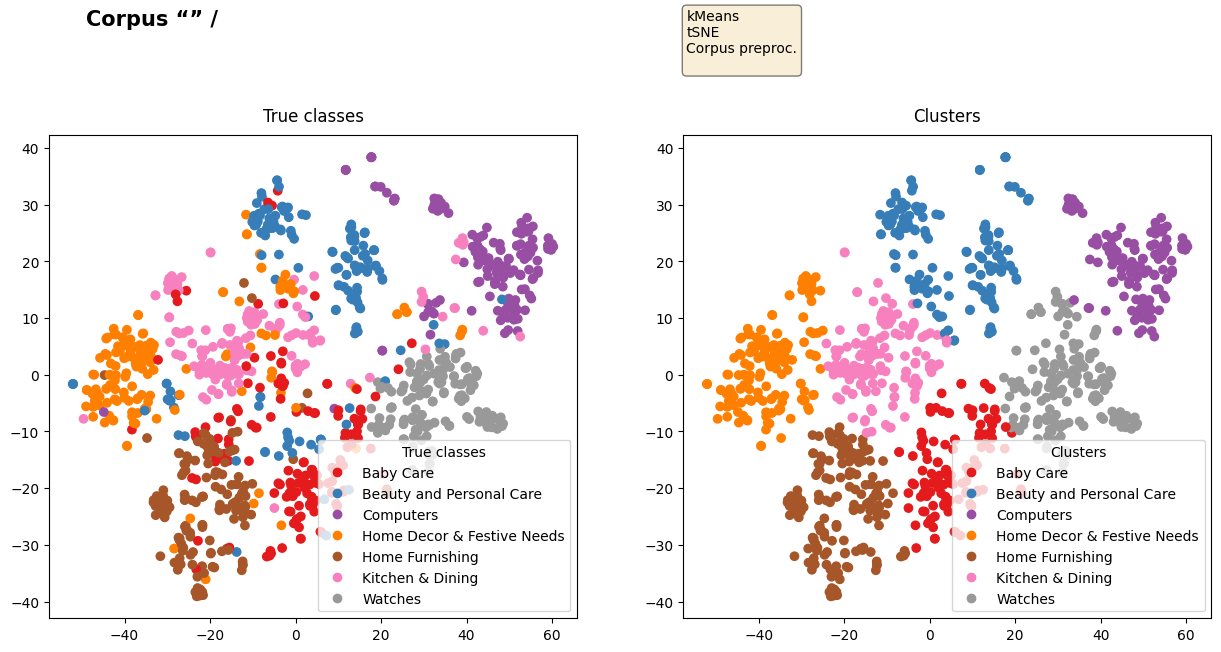

In [40]:
from pepper_utils import print_subtitle
from flipkart_utils import get_class_label_name_map
from tx_ml import tsne_kmeans_ari, show_tsne
print_subtitle("tSNE and ARI")
X_tsne, clu_labels, ari, total_time, tsne_params = \
    tsne_kmeans_ari(bert_mean_features, cla_labels)

print_subtitle("Plot")
cla_names = list(get_class_label_name_map().values())
show_tsne(
    cla_labels, cla_names, X_tsne, clu_labels, #ari, f"BERT embedded {name} t-SNE clustering"
)

In [41]:
from sklearn import metrics
ari = metrics.adjusted_rand_score(cla_labels, clu_labels)
print("ARI:", ari)

ARI: 0.557416808587881



tSNE and ARI

Plot


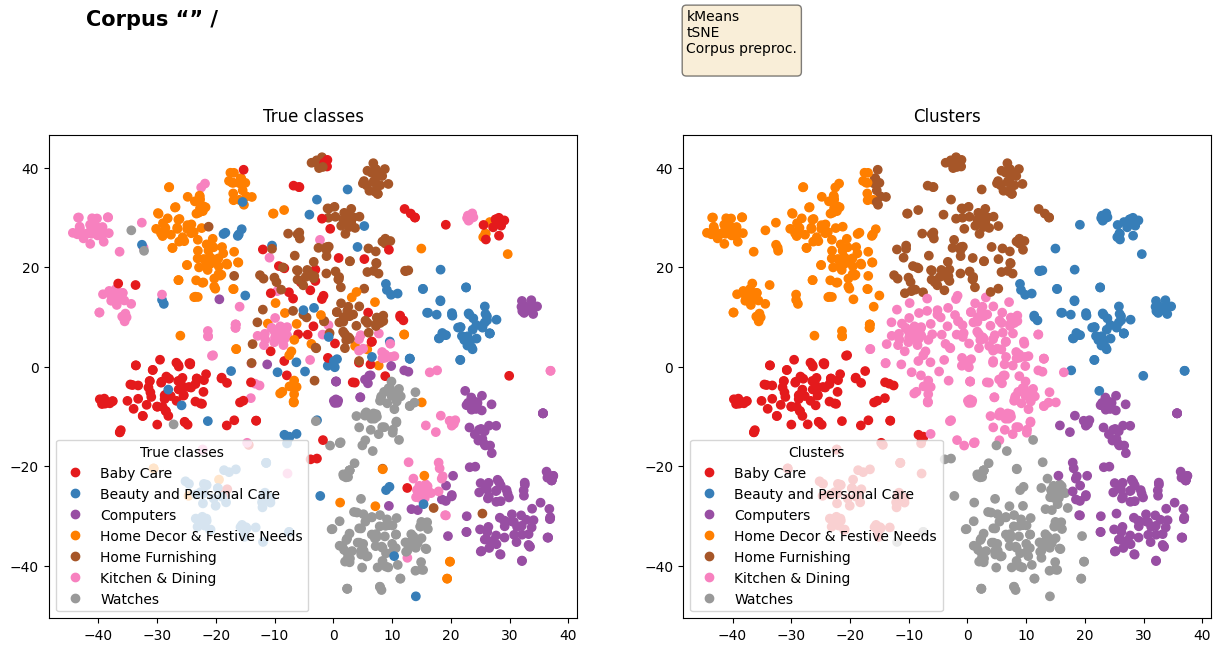

In [42]:
from pepper_utils import print_subtitle
from flipkart_utils import get_class_label_name_map
from tx_ml import tsne_kmeans_ari, show_tsne
print_subtitle("tSNE and ARI")
X_tsne, clu_labels, ari, total_time, tsne_params = \
    tsne_kmeans_ari(bert_max_features, cla_labels)

print_subtitle("Plot")
cla_names = list(get_class_label_name_map().values())
show_tsne(
    cla_labels, cla_names, X_tsne, clu_labels, #ari, f"BERT embedded {name} t-SNE clustering"
)

In [43]:
from sklearn import metrics
ari = metrics.adjusted_rand_score(cla_labels, clu_labels)
print("ARI:", ari)

ARI: 0.318416756571568



tSNE and ARI

Plot


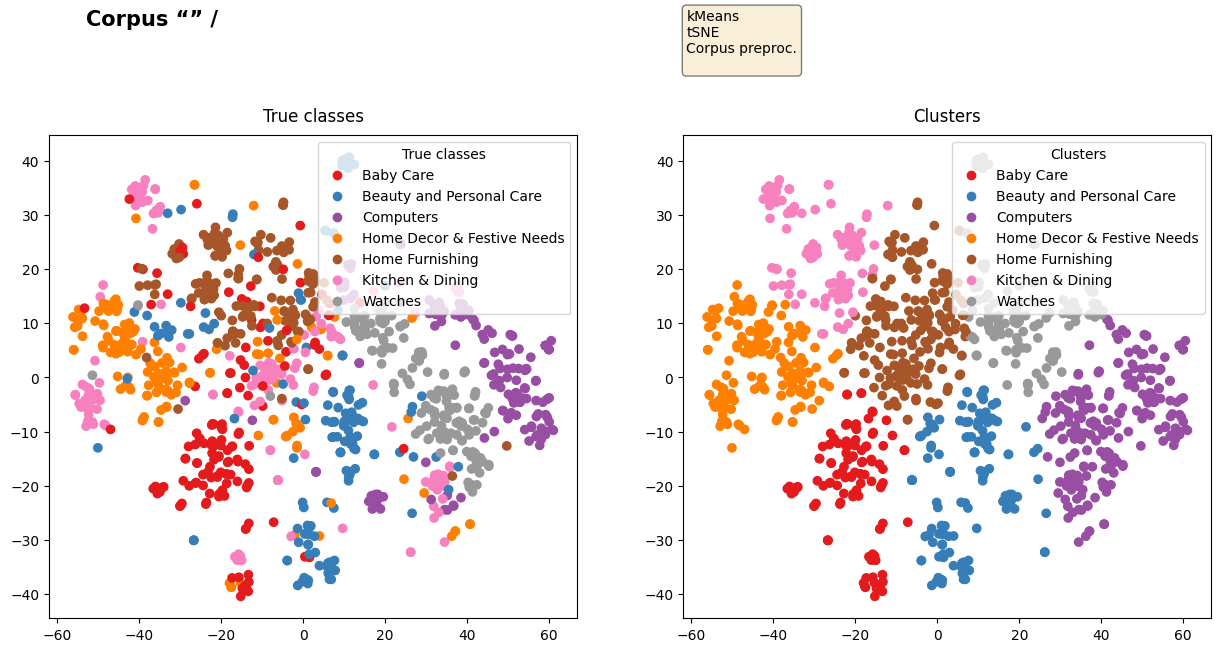

In [44]:
from pepper_utils import print_subtitle
from flipkart_utils import get_class_label_name_map
from tx_ml import tsne_kmeans_ari, show_tsne
print_subtitle("tSNE and ARI")
X_tsne, clu_labels, ari, total_time, tsne_params = \
    tsne_kmeans_ari(bert_min_features, cla_labels)

print_subtitle("Plot")
cla_names = list(get_class_label_name_map().values())
show_tsne(
    cla_labels, cla_names, X_tsne, clu_labels, #ari, f"BERT embedded {name} t-SNE clustering"
)

In [45]:
from sklearn import metrics
ari = metrics.adjusted_rand_score(cla_labels, clu_labels)
print("ARI:", ari)

ARI: 0.2971795522816605



tSNE and ARI

Plot


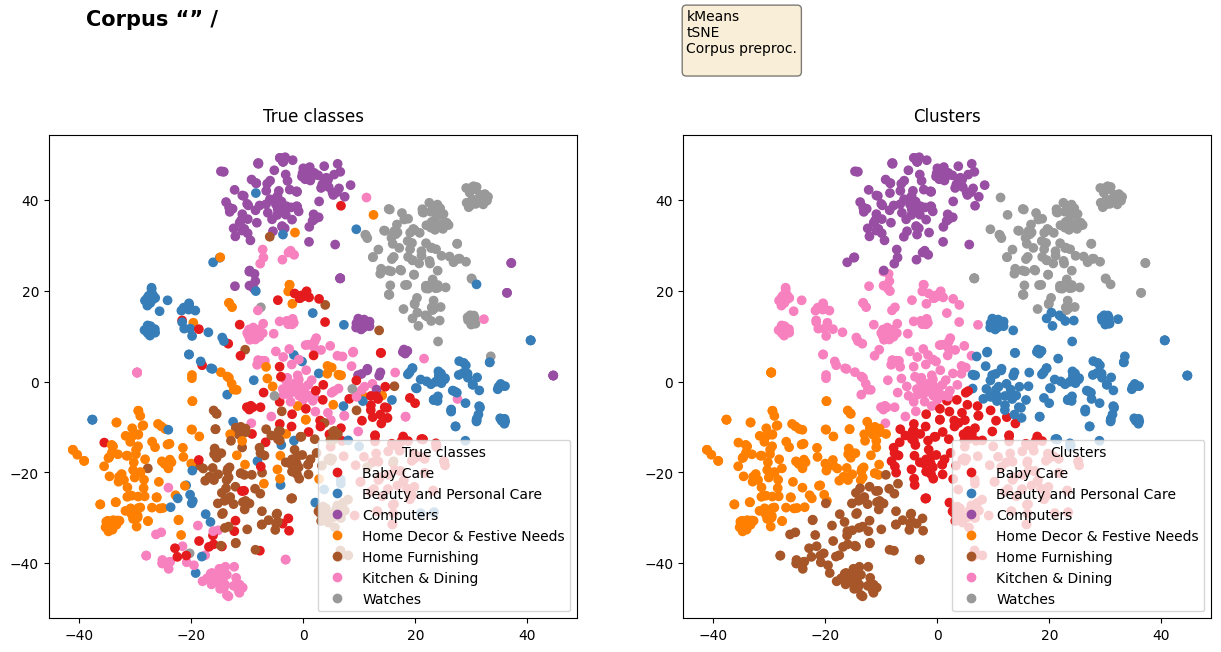

In [46]:
from pepper_utils import print_subtitle
from flipkart_utils import get_class_label_name_map
from tx_ml import tsne_kmeans_ari, show_tsne
print_subtitle("tSNE and ARI")
X_tsne, clu_labels, ari, total_time, tsne_params = \
    tsne_kmeans_ari(bert_fav_left_features, cla_labels)

print_subtitle("Plot")
cla_names = list(get_class_label_name_map().values())
show_tsne(
    cla_labels, cla_names, X_tsne, clu_labels, #ari, f"BERT embedded {name} t-SNE clustering"
)

In [47]:
from sklearn import metrics
ari = metrics.adjusted_rand_score(cla_labels, clu_labels)
print("ARI:", ari)

ARI: 0.3483002480615394



tSNE and ARI

Plot


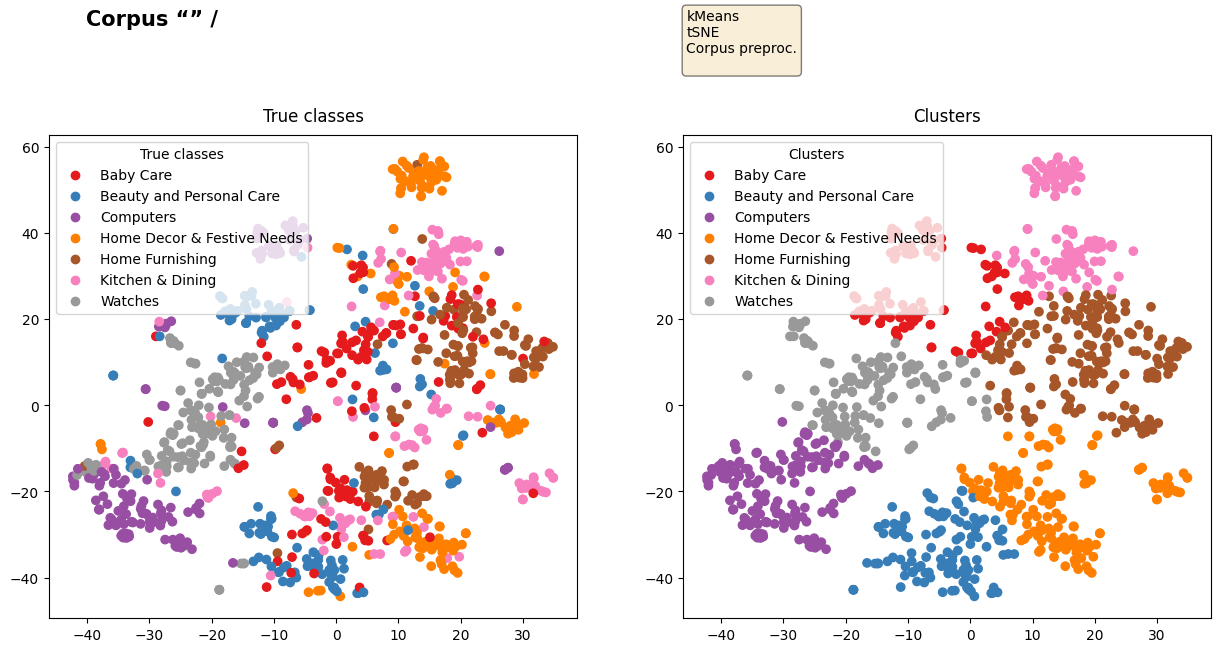

In [50]:
from pepper_utils import print_subtitle
from flipkart_utils import get_class_label_name_map
from tx_ml import tsne_kmeans_ari, show_tsne
print_subtitle("tSNE and ARI")
X_tsne, clu_labels, ari, total_time, tsne_params = \
    tsne_kmeans_ari(bert_fav_right_features, cla_labels)

print_subtitle("Plot")
cla_names = list(get_class_label_name_map().values())
show_tsne(
    cla_labels, cla_names, X_tsne, clu_labels, #ari, f"BERT embedded {name} t-SNE clustering"
)

In [51]:
from sklearn import metrics
ari = metrics.adjusted_rand_score(cla_labels, clu_labels)
print("ARI:", ari)

ARI: 0.2224370164629444
